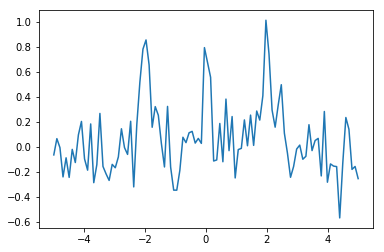

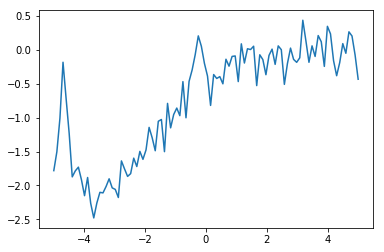

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 100, 50)           300       
_________________________________________________________________
flatten_10 (Flatten)         (None, 5000)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 20)                100020    
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 42        
Total params: 100,362
Trainable params: 100,362
Non-trainable params: 0
_________________________________________________________________
Train on 320 samples, validate on 80 samples
Epoch 1/20
320/320 [==============================] - 2s 7ms/step - loss: 1.4671 - acc: 0.6594 - val_loss: 0.8566 - val_acc: 0.8375

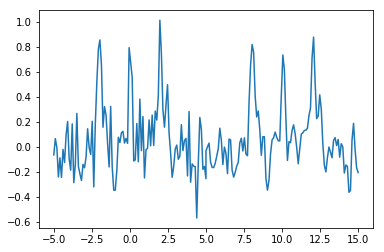

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_8 (Reshape)          (None, 100, 2, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 2, 50)        300       
_________________________________________________________________
flatten_11 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 20)                200020    
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 42        
Total params: 200,362
Trainable params: 200,362
Non-trainable params: 0
_________________________________________________________________
Train on 320 samples, validate on 80 samples
Epoch 1/20
320/320 [==============================] - 2s 8ms/step - loss: 2.7161 - acc: 0.4

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import scipy.signal as signal
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv1D, MaxPooling1D, Conv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

def gauss(x, *p):
    # Define model function to be used to make artificial spectra
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def sumOfGaussians(x,ps,noise=False):
    # sum of gaussians
    result=0
    for p in ps:
        result+=gauss(x,*p)
    if (noise):
        result+=.2*np.random.randn(len(result))
    return result

def generateSampleData(x,trueSample,numSamples):
    if (trueSample):
        trueData=[[1,0,.1],[1,2,.1],[1,-2,.1]]
        trueSamples=[]
        for i in range(numSamples):
            trueSamples.append(sumOfGaussians(x,trueData,True))
        return trueSamples
    else:
        falseSamples=[]
        for i in range(numSamples):
            falseData=np.random.randn(3,3)
            falseData[0]*=3
            falseData[1]*=4
            falseSamples.append(sumOfGaussians(x,falseData,True))
        return falseSamples
    return 0

# instead of the training data just being the function of frequency, attach the convolution with myFilter
# at the end so it is still 1d but twice as long
def attachMatchedFilter(trainingData,myFilter):
    myFilter=myFilter/sum(myFilter)
    numSamples=trainingData.shape[0]
    filteredData=[]
    for i in range(numSamples):
        filteredData.append(signal.convolve(trainingData[i],myFilter,mode='same'))
    return np.append(trainingData,filteredData,axis=-1)

x = np.linspace(-5,5,100)
trueTrainNum=200
trueTrainingSamples=generateSampleData(x,True,trueTrainNum)
plt.plot(x,trueTrainingSamples[0])
plt.show()
falseTrainNum=200
falseTrainingSamples=generateSampleData(x,False,falseTrainNum)
plt.plot(x,falseTrainingSamples[0])
plt.show()
train_X=np.array(trueTrainingSamples)
train_X=np.append(train_X,np.array(falseTrainingSamples),axis=0)
train_Y=np.append(np.zeros(trueTrainNum),np.ones(falseTrainNum))
train_Y_one_hot=to_categorical(train_Y)

# without the matched filter attached
train_X2 = train_X.reshape(-1,100,1)
train_X2,valid_X2,train_label2,valid_label2 = train_test_split(train_X2, train_Y_one_hot, test_size=0.2, random_state=13)
batch_size = 64
epochs = 20
num_classes = 2
spectra_model = Sequential()
spectra_model.add(Conv1D(50, kernel_size=(5),activation='linear',input_shape=(100,1),padding='same'))
spectra_model.add(Flatten())
spectra_model.add(Dense(20))
spectra_model.add(Dense(num_classes, activation='softmax'))
spectra_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
spectra_model.summary()
spectra_train = spectra_model.fit(train_X2, train_label2, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X2, valid_label2))

# with the matched filter attached
train_X=attachMatchedFilter(train_X,signal.gaussian(100,.1))
plt.plot(np.append(x,x+10),train_X[0])
plt.show()
train_X=train_X.reshape(-1,200,1)
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)
batch_size = 64
epochs = 20
num_classes = 2
spectra_model = Sequential()
spectra_model.add(Reshape((100,2,1),input_shape=(200,1)))
spectra_model.add(Conv2D(50, kernel_size=(5,1),activation='linear',padding='same'))
spectra_model.add(Flatten())
spectra_model.add(Dense(20))
spectra_model.add(Dense(num_classes, activation='softmax'))
spectra_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
spectra_model.summary()
spectra_train = spectra_model.fit(train_X, train_label, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_label))

trueValNum=5
falseValNum=5
trueValidationSamples=generateSampleData(x,True,trueValNum)
falseValidationSamples=generateSampleData(x,False,falseValNum)